In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

### Quelle est la forme du DataFrame ?

In [2]:
# Chargement des données
df = pd.read_csv("train.csv")

# 1. Aperçu des données
print("\nAperçu du DataFrame:")
print(df.info())


Aperçu du DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Y a-t-il des valeurs manquantes ou des valeurs dupliquées ?

In [4]:
# 2. Vérification des valeurs manquantes et dupliquées
print("\nValeurs manquantes par colonne:")
print(df.isnull().sum())
print("\nNombre de lignes dupliquées:", df.duplicated().sum())


Valeurs manquantes par colonne:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Nombre de lignes dupliquées: 0


### Quelles sont les colonnes qui vont nous intéresser ?

In [5]:
# 3. Sélection des colonnes importantes
colonnes_importantes = ['text', 'target']
df = df[colonnes_importantes]
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### Y a-t-il des données aberrantes ou des incohérences majeures ?

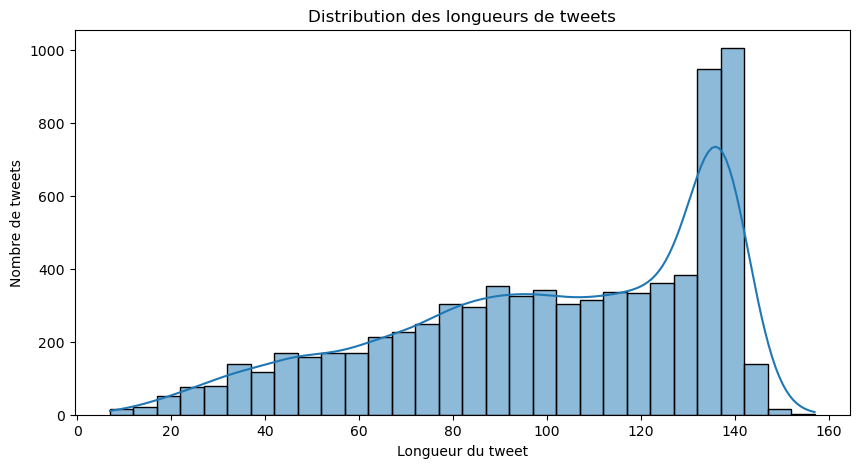

In [6]:
# 4. Analyse des longueurs des tweets
df['tweet_length'] = df['text'].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Distribution des longueurs de tweets")
plt.xlabel("Longueur du tweet")
plt.ylabel("Nombre de tweets")
plt.show()

### Y a-t-il des tweets anormalement longs ou courts ? Peut-on les considérer comme des outliers ?

## Analyse des longueurs de tweets

### Observations :
- La majorité des tweets semblent avoir une longueur comprise entre **60 et 140 caractères**.
- Il y a une forte concentration autour de **130-140 caractères**, ce qui est logique car Twitter impose une limite de **280 caractères** (ou **140 dans l'ancienne version**).
- Très peu de tweets ont une longueur inférieure à **20 caractères** ou supérieure à **150 caractères**.

### Détection des outliers :
- **Tweets courts (< 20 caractères)** : Peu fréquents, ils pourraient être des **spams, des réponses brèves ou des tweets mal formatés**.
- **Tweets longs (> 150 caractères)** : Rares aussi, ils peuvent contenir du **contenu copié-collé ou une structure inhabituelle**.

In [7]:
# 5. Ratio de tweets catastrophes vs normaux
print("\nRépartition des tweets:")
print(df['target'].value_counts(normalize=True) * 100)


Répartition des tweets:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


### Quel est le ratio de tweets parlant de “catastrophes” par rapport aux tweets normaux ?

#### target = 1 --> tweet parlant de catastrophe
#### target = 0 --> tweet normal

In [8]:
# Compter le nombre de tweets par catégorie
catastrophe_count = df[df['target'] == 1].shape[0]
normal_count = df[df['target'] == 0].shape[0]

# Calcul du ratio
ratio = catastrophe_count / normal_count

# Affichage des résultats
print(f"Nombre de tweets sur les catastrophes : {catastrophe_count}")
print(f"Nombre de tweets normaux : {normal_count}")
print(f"Ratio catastrophe / normal : {ratio:.2f}")

Nombre de tweets sur les catastrophes : 3271
Nombre de tweets normaux : 4342
Ratio catastrophe / normal : 0.75


### En regardant quelques tweets au hasard, peut-on deviner facilement la "target" ?

In [9]:
# 6. Affichage de quelques tweets aléatoires
print("\nQuelques tweets aléatoires:")
print(df.sample(5))


Quelques tweets aléatoires:
                                                   text  target  tweet_length
3288  Disaster control teams are studying ways to ev...       1           110
2493  @binellithresa TY for the follow Go To http://...       1           132
7011                      Drunk twister is so hard ????       0            29
3201  Storm concludes City of Calgary's Municipal Em...       1            93
2782  More Natural Disaster Research Urgent http://t...       1            77


### Peut-on déjà détecter des patterns ou des mots-clés dans les tweets ?

In [10]:
# 7. Détection de mots-clés
from collections import Counter
import re

def extract_words(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

all_words = df['text'].apply(extract_words).sum()
word_freq = Counter(all_words)

print("\nTop 10 mots les plus fréquents:")
print(word_freq.most_common(10))


Top 10 mots les plus fréquents:
[('t', 5199), ('co', 4740), ('http', 4309), ('the', 3277), ('a', 2200), ('in', 1986), ('to', 1949), ('of', 1830), ('i', 1778), ('and', 1426)]


## 2 - Text Processing

### 1. Fonction de traitement du texte

On définit une fonction qui :  
- Tokenize le texte  
- Supprime les stopwords  
- Supprime les tokens de moins de 3 lettres  
- Convertit tout en minuscule  

In [11]:
import nltk
nltk.download('punkt', download_dir="C:/nltk_data")
nltk.download('stopwords', download_dir="C:/nltk_data")

[nltk_data] Downloading package punkt to C:/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [24]:
import os  # <-- Ajoute cette ligne
import nltk
import shutil

nltk.data.path.append("C:/Users/oba3994/AppData/Roaming/nltk_data")

# Supprimer punkt s'il existe
punkt_path = "C:/Users/oba3994/AppData/Roaming/nltk_data/tokenizers/punkt"
if os.path.exists(punkt_path):
    shutil.rmtree(punkt_path)
    print("✅ punkt supprimé avec succès !")

# Télécharger à nouveau
nltk.download("punkt")

✅ punkt supprimé avec succès !


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oba3994\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
 
# Télécharger les ressources nécessaires
nltk.download('punkt')        # Pour la tokenisation
nltk.download('stopwords')    # Liste de mots inutiles (stopwords)
nltk.download('wordnet')      # Pour la lemmatisation
nltk.download('omw-1.4')      # Dictionnaire de lemmatisation
 
# Liste des stopwords en français (ajouter d'autres langues si besoin)
stop_words = set(stopwords.words('english'))  # Change 'english' si le dataset est en français
 
# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()
 
# Fonction de nettoyage du texte
def preprocess_text(text):
    # Tokenisation
    tokens = word_tokenize(text.lower())  # Conversion en minuscule + tokenisation
    # Suppression des stopwords et des tokens courts
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2]
    # Lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)
 
# Appliquer la fonction sur la colonne 'text'
df["text_clean"] = df["text"].apply(preprocess_text)
 
# Afficher un aperçu avant/après
print(df[["text", "text_clean"]].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oba3994\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oba3994\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oba3994\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\oba3994\AppData\Roaming\nltk_data...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\oba3994/nltk_data'
    - 'C:\\Anaconda\\nltk_data'
    - 'C:\\Anaconda\\share\\nltk_data'
    - 'C:\\Anaconda\\lib\\nltk_data'
    - 'C:\\Users\\oba3994\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [14]:
# Définition des stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    """
    Fonction pour nettoyer et tokeniser un texte.
    """
    if isinstance(text, str):  # Vérifie si le texte est bien une string
        text = text.lower()  # Convertir en minuscule
        tokens = word_tokenize(text)  # Tokenization
        tokens = [word for word in tokens if word not in stop_words]  # Supprimer stopwords
        tokens = [word for word in tokens if len(word) > 2]  # Supprimer tokens < 3 lettres
        tokens = [word for word in tokens if word not in string.punctuation]  # Supprimer la ponctuation
        return tokens
    return []  # Retourner une liste vide si le texte est NaN

# Exemple d'application sur un tweet
example_text = "Breaking news! A big earthquake just happened in California!!!"
print(preprocess_text(example_text))

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\oba3994/nltk_data'
    - 'C:\\Anaconda\\nltk_data'
    - 'C:\\Anaconda\\share\\nltk_data'
    - 'C:\\Anaconda\\lib\\nltk_data'
    - 'C:\\Users\\oba3994\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
